In [1]:
from quagmire import SurfaceProcessMesh
from quagmire import tools as meshtools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import petsc4py


In [2]:
import h5py

meshFile = h5py.File(name="../Scripts/Octopants.h5", mode="r")
points = meshFile["geometry"]["vertices"]
x1 = points.value[:,0]
y1 = points.value[:,1]
bmask = meshFile["fields"]["bmask"].value[:].astype(bool)
height = meshFile["fields"]["height"].value[:]
lakes = meshFile["fields"]["swamps"].value[:]

In [3]:
dm  = meshtools.create_DMPlex_from_points(x1,y1,bmask=bmask)
SPM = SurfaceProcessMesh(dm)
x = SPM.coords[:,0]
y = SPM.coords[:,1]


0 - Delaunay triangulation 0.252974s
0 - Calculate node weights and area 0.004288s
0 - Find boundaries 0.001738s
0 - cKDTree 0.017854s
0 - Construct neighbour cloud array 0.503618s
0 - Construct rbf weights 0.109182s


In [4]:
from scipy.spatial import ckdtree
old_nodes = ckdtree.cKDTree( points.value )

In [5]:
distance, mapping = old_nodes.query(SPM.coords)
SPM.update_height(height[mapping])
lakefill = lakes[mapping]

0 - Compute slopes 0.302913s
0 - Build downhill matrices 0.298412s


In [6]:
its, flowpaths2 = SPM.cumulative_flow_verbose(SPM.area, maximum_its=2000, verbose=True)

0: Max Delta - 0.00468897280374 
10: Max Delta - 0.00383216848247 
20: Max Delta - 0.00414514885071 
30: Max Delta - 0.00351076695607 
40: Max Delta - 0.0043621380974 
50: Max Delta - 0.00306028525074 
60: Max Delta - 0.00372167512453 
70: Max Delta - 0.00720552713863 
80: Max Delta - 0.00328881114693 
90: Max Delta - 0.00270917424239 
100: Max Delta - 0.00370359694084 
110: Max Delta - 0.00336187479349 
120: Max Delta - 0.00297268070786 
130: Max Delta - 0.00204285060859 
140: Max Delta - 0.00236725161181 
150: Max Delta - 0.00282198865924 
160: Max Delta - 0.00325633415871 
170: Max Delta - 0.00196507633237 
180: Max Delta - 0.00191560639388 
190: Max Delta - 0.00185070266629 
200: Max Delta - 0.00233405856947 
210: Max Delta - 0.00236495390773 
220: Max Delta - 0.00159685274977 
230: Max Delta - 0.00233236042028 
240: Max Delta - 0.00335272744813 
250: Max Delta - 0.00347646299508 
260: Max Delta - 0.00413760202983 
270: Max Delta - 0.00233391628851 
280: Max Delta - 0.0008852882390

In [7]:
low_points = SPM.identify_low_points()
print low_points

[ 5282  6182  8803 28458 33062 55554 83136]


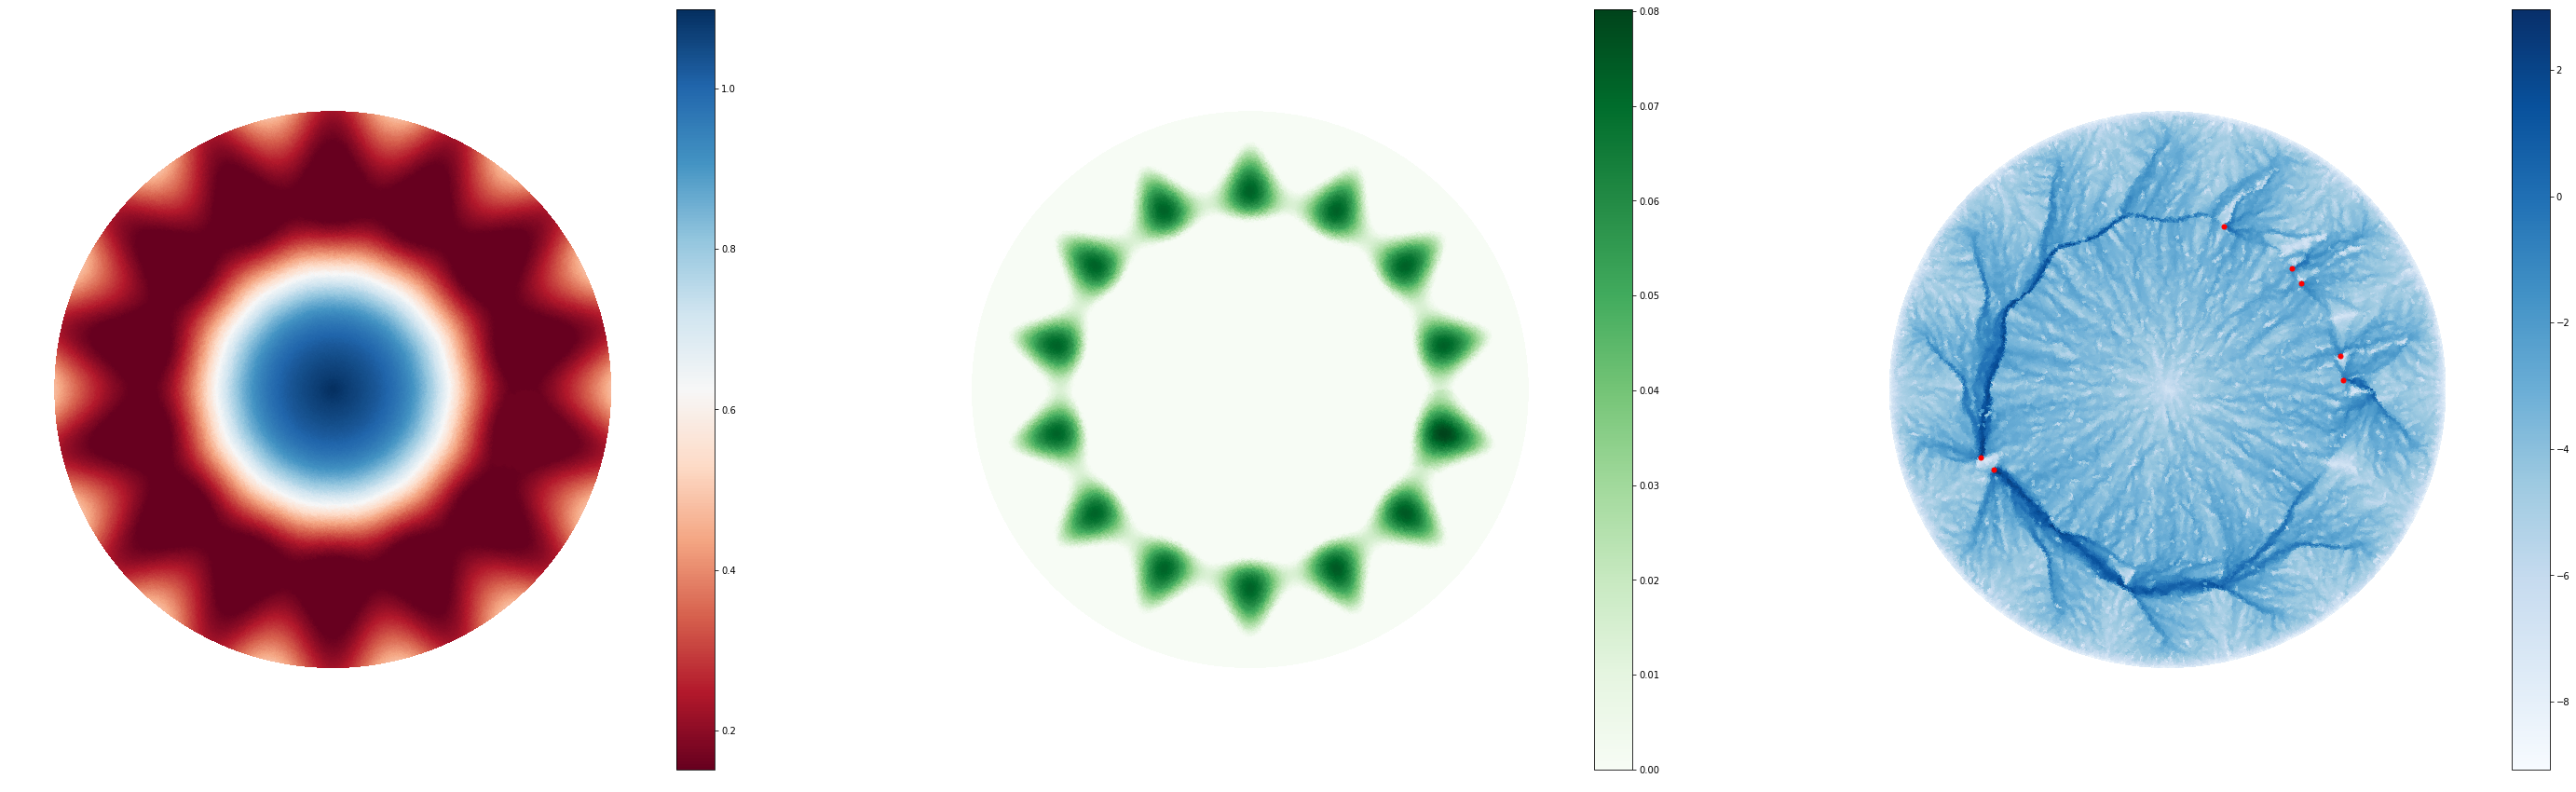

In [8]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(50,15))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')

    
im1 = ax1.tripcolor(x, y, SPM.tri.simplices, SPM.height, cmap=plt.cm.RdBu)    
# ax1.tripcolor(x, y, SPM.tri.simplices, height, 10)

# im1 = ax1.tripcolor(x, y, sp.tri.simplices, sp.height, cmap=plt.cm.terrain)
im2 = ax2.tripcolor(x, y, SPM.tri.simplices, lakefill, cmap='Greens', vmax=None)

# ax3.tripcolor(x, y, SPM.tri.simplices, height, cmap=plt.cm.gray, zorder=1, vmin=-0.75, alpha=0.5)
im3 = ax3.tripcolor(x, y, SPM.tri.simplices, np.log(flowpaths2), cmap='Blues', zorder=0)
ax3.scatter(x[low_points], y[low_points], color="Red", s=25.0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()



In [10]:
from petsc4py import PETSc



In [69]:
vec = SPM.gvec.duplicate()
vec.setName("noname")

filename = "test0.h5"

SPM.save_mesh_to_hdf5(filename)

viewh5 = PETSc.Viewer()
viewh5.createHDF5(filename, mode='a', comm=dm.comm)
viewh5.view(obj=vec)
viewh5.destroy()



In [70]:
testFile = h5py.File(name=filename, mode="r")



In [71]:
testFile.keys()

[u'fields', u'geometry', u'labels', u'topology', u'vertex_fields', u'viz']

In [68]:
rm test0.h5
